# Deep Pose Implementation
**Purpose**
This project was created as part of a graduate course in computer vision at the University of Michigan (EECS 442). The objective of this project was to create a working implementation of stage 1 of the [Deep Pose Paper](https://openaccess.thecvf.com/content_cvpr_2014/papers/Toshev_DeepPose_Human_Pose_2014_CVPR_paper.pdf) on the Microsoft Common Objects in Context dataset.

**Instructions**
To run this project and train a model on COCO perform the following:
- Run `pip install -r requirements.txt` in the main project directory
- Run each cell of this notebook

If you follow these instructions you will download a 2.9GB subset of COCO and train a stage one Deep Pose estimation model on that data. Further instructions can be found in each cell below.

In [7]:
import gdown

In [8]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [10]:
# Download dataset from google drive
gdown.download('https://drive.google.com/uc?id=1ioRIMhfxZCKGvXI6j-69S-qJ20NFXE4n', 'data.zip', quiet=True)

# Otherwise run dataset-generator.ipynb to create dataset

!unzip -q data.zip

In [11]:
import numpy as np
import torch
from torch.utils import data
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib import image
from matplotlib import patches
import zipfile
from pycocotools.coco import COCO
import pandas as pd
import cv2
import random as rn
from datetime import datetime
import ipywidgets
%matplotlib inline

In [12]:
# Import downloaded COCO dataset descriptors as pandas dataframes
train_df = pd.read_pickle('train_df.pkl')
val_df = pd.read_pickle('val_df.pkl')

In [13]:
# Fix the dataframes by applying the following changes:
# Normalize each keypoint between 0 and 1
# Set x, y, and z to 0 if the keypoint is outside the image bounds, occluded, or not in the image
# Drop data points with more than 4 keypoints missing

drop = []
for row in range(len(train_df)):
    keypoints = train_df.iloc[row]['keypoints']
    if 'c' in train_df.iloc[row]['path']:
        drop.append(row)
        continue
    
    # Add 0.5 to all keypoints as they were normalized between -0.5 to 0.5
    keypoints = keypoints.reshape(-1, 3)
    keypoints[:,0:2] += 0.5
    
    # If x == 0 or y == 0 or v == 0 set x,y,v to 0
    v_0_indices = np.where((keypoints[:,2] == 0))[0]
    y_0_indices = np.where((keypoints[:,1] == 0))[0]
    x_0_indices = np.where((keypoints[:,0] == 0))[0]
    keypoints[v_0_indices] = [0,0,0]
    keypoints[y_0_indices] = [0,0,0]
    keypoints[x_0_indices] = [0,0,0]
    
    keypoints = keypoints.reshape(-1)

    # Drop rows with 5 or less keypoints
    if len(v_0_indices.reshape(-1)) > 5:
        drop.append(row)
    else:
        train_df.at[row, 'keypoints'] = keypoints

train_df = train_df.drop(drop)

drop = []
for row in range(len(val_df)):
    keypoints = val_df.iloc[row]['keypoints']
    if 'c' in val_df.iloc[row]['path']:
        drop.append(row)
        continue
    
    # Add 0.5 to all kps
    keypoints = keypoints.reshape(-1, 3)
    keypoints[:,0:2] += 0.5
    
    # If x == 0 or y == 0 or v == 0 set x,y,v to 0
    v_0_indices = np.where((keypoints[:,2] == 0))[0]
    y_0_indices = np.where((keypoints[:,1] == 0))[0]
    x_0_indices = np.where((keypoints[:,0] == 0))[0]
    keypoints[v_0_indices] = [0,0,0]
    keypoints[y_0_indices] = [0,0,0]
    keypoints[x_0_indices] = [0,0,0]
    
    keypoints = keypoints.reshape(-1)
    
    # Drop rows with 5 or less keypoints

    if len(v_0_indices.reshape(-1)) > 5:
        drop.append(row)
    else:
        val_df.at[row, 'keypoints'] = keypoints
        
val_df = val_df.drop(drop)

print(len(train_df))
print(len(val_df))

29281
1164


In [16]:
# Takes in a CxHxW image with keypoints and displays it
# Not the cleanest code but it works

kp_names = [ "nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder", "right_shoulder", "left_elbow", 
    "right_elbow", "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle" ]

kp_dict = {name:i*3 for i, name in enumerate(kp_names)}

# Takes in a CXHXW image with keypoints and displays it with keypoints
def displayImageWithKeyPoints(img, keypoints, ax=None, show=True):
    img = np.swapaxes(img,0,2)
    img = np.swapaxes(img,0,1)

    if(ax is None):
        fig, ax = plt.subplots()
    ax.imshow(img)
    w = img.shape[1]
    h = img.shape[0]
    
    # Show key points
    for i in range(2, len(keypoints), 3):
        if(i > 1 and i < 10): 
            continue
        x = keypoints[i-2]
        y = keypoints[i-1]
        v = keypoints[i]
        x = (x)*w
        y = (y)*h
        if v < 0.7: continue
        ax.plot(x, y, marker='o', color='black')

    # Draw skeleton
    left_arm = ["left_shoulder", "left_elbow", "left_wrist"]
    right_arm = ["right_shoulder", "right_elbow", "right_wrist"]
    left_leg = ["left_hip", "left_knee", "left_ankle"]
    right_leg = ["right_hip", "right_knee", "right_ankle"]

    bones = [left_arm, right_arm, left_leg, right_leg]
    colors = ['red', 'blue', 'green', 'yellow']

    for i, bone in enumerate(bones):
        x_l = []
        y_l = []
        for keypoint in bone:
            idx = kp_dict[keypoint]
            x = keypoints[idx]*w
            y = keypoints[idx+1]*h
            if x < 0 or y == 0: continue
            x_l.append(x)
            y_l.append(y)
        
        ax.plot(x_l, y_l, color=colors[i], linewidth=2)
    
    # torso:
    torso_upper_x = (keypoints[kp_dict["left_shoulder"]] + keypoints[kp_dict["right_shoulder"]])/2 * w
    torso_upper_y = (keypoints[kp_dict["left_shoulder"]+1] + keypoints[kp_dict["right_shoulder"]+1])/2 * h
    torso_lower_x = (keypoints[kp_dict["left_hip"]] + keypoints[kp_dict["right_hip"]])/2 * w
    torso_lower_y = (keypoints[kp_dict["left_hip"]+1] + keypoints[kp_dict["right_hip"]+1])/2 * h
    torso_x = [torso_upper_x, torso_lower_x]
    torso_y = [torso_upper_y, torso_lower_y]
    ax.plot(torso_x, torso_y, color='magenta', linewidth=2)

    # connectors 
    face_c_x = [torso_upper_x, keypoints[kp_dict["nose"]]*w]
    face_c_y = [torso_upper_y, keypoints[kp_dict["nose"]+1]*h]
    if 0 not in face_c_x and 0 not in face_c_y: ax.plot(face_c_x, face_c_y, color='white', linewidth=2)

    upleft_c_x = [torso_upper_x, keypoints[kp_dict["left_shoulder"]]*w]
    upleft_c_y = [torso_upper_y, keypoints[kp_dict["left_shoulder"]+1]*h]
    if 0 not in upleft_c_x and 0 not in upleft_c_y: ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)

    upleft_c_x = [torso_upper_x, keypoints[kp_dict["right_shoulder"]]*w]
    upleft_c_y = [torso_upper_y, keypoints[kp_dict["right_shoulder"]+1]*h]
    if 0 not in upleft_c_x and 0 not in upleft_c_y: ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)

    upleft_c_x = [torso_lower_x, keypoints[kp_dict["left_hip"]]*w]
    upleft_c_y = [torso_lower_y, keypoints[kp_dict["left_hip"]+1]*h]
    if 0 not in upleft_c_x and 0 not in upleft_c_y: ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)

    upleft_c_x = [torso_lower_x, keypoints[kp_dict["right_hip"]]*w]
    upleft_c_y = [torso_lower_y, keypoints[kp_dict["right_hip"]+1]*h]
    if 0 not in upleft_c_x and 0 not in upleft_c_y: ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)

    if(show):
        plt.show()


In [17]:
# Create a pytorch dataset which will be used for training and validation dataloaders
class Coco(Dataset):
    def __init__(self, df, source, dimensions, transform=None):
        super().__init__()
        # Dataframe of annotations
        self.df = df
        # Either train or val to indicate set
        self.source = source
        # Square dimensions of image
        self.dimensions = dimensions
        # transform
        self.transform = transform

    def __getitem__(self, index):
        # Get data
        img = image.imread(f'{self.source}2017/{self.df.iloc[index]["path"]}')
        
        # Apply transforms to image
        if self.transform: img = self.transform(img)
        
        # Return data
        return img, torch.FloatTensor(self.df.iloc[index]["keypoints"])#.reshape(-1, 3)[:, 0:2].reshape(-1)

    def __len__(self):
        return len(self.df)

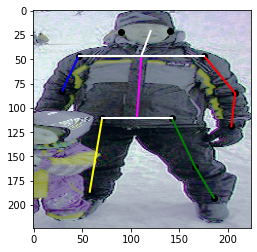

In [18]:
# Test data loader and show an image with keypoints
composed_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=.3, hue=0.2),
    transforms.RandomPosterize(bits=6),
    transforms.RandomSolarize(245, p=0.05),
    transforms.RandomAdjustSharpness(5, p=0.2),
    transforms.RandomAutocontrast(),
    transforms.RandomEqualize(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
train_dataloader = DataLoader(
    dataset=Coco(train_df, 'train', 224, transform=composed_transforms),
    batch_size=1, shuffle=True, num_workers=0
)

# Example from data loader after normalization
img, labels = iter(train_dataloader).next()
a = img[0].numpy()
b = (a - np.min(a))/np.ptp(a)
displayImageWithKeyPoints(b, labels[0])

In [ ]:
# Initialize network
# Switch to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.autograd.set_detect_anomaly(True)
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("No GPU")

In [ ]:
# Define batch size
batch_size = 32

In [ ]:
# Load datasets
train_dataset = Coco(train_df, 'train', 224, transform=composed_transforms)
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=2
)

val_dataset = Coco(val_df, 'val', 224, transform=composed_transforms)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size, shuffle=True, num_workers=2
)

In [ ]:
def l2_loss_masked(output, target):
    out = output.reshape(-1, 3)
    tar = target.reshape(-1, 3)
    
    not_present_tar_indices = torch.where((tar[:,2] == 0))[0]
    mask = torch.ones_like(out).to(device)
    mask[not_present_tar_indices] = torch.tensor([0.,0.,1]).to(device)
    
    return torch.sum(mask*(out - tar)**2)

In [ ]:
# Define accuracy checking step
def check_validation_accuracy(model):
    criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
    with torch.no_grad():
        loss = 0
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get predictions
            outputs = model(inputs)
            loss += l2_loss_masked(outputs, labels).item()

        print(f"Validiation loss was {loss}")
    
    # visualize some random gt vs prediction
    idx = rn.randint(0, 100)
    img, labels = val_dataset[idx]
    a = img.numpy()
    b = (a - np.min(a))/np.ptp(a)
    
    img = img.to(device)
    outputs = model(img.unsqueeze(0))
    outputs = outputs.to('cpu')

    fig, (ax0, ax1) = plt.subplots(1, 2)
    displayImageWithKeyPoints(b, labels, ax0, False)
    displayImageWithKeyPoints(b, outputs[0].detach().numpy(), ax1, True)

    return loss 

In [ ]:
def train(model, epochs, val_nodecrease_cutoff):
    criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
    optimizer = optim.Adagrad(model.parameters(), lr=0.0009, lr_decay=0, weight_decay=0.01, initial_accumulator_value=0, eps=1e-10)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.75)

    print(f"Training {epochs} epochs. Dataset is {len(train_dataset)} big. Using batch size {batch_size}")
    print(f"{len(train_dataset) // batch_size + 1} minibatches are needed per epoch")

    train_loss_history = []
    val_loss_history = []

    min_val_loss = (0, 9999999999999)
    for epoch in range(epochs):

        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = l2_loss_masked(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 250 == 0:
                print(f"Minibatch {i+1}/{len(train_dataset)//batch_size+1}. Loss {loss.item()}")

        running_loss = running_loss / len(train_df)
        scheduler.step()

        # print statistics
        print(f'Epoch {epoch}/{epochs}. Loss {running_loss}. {datetime.now().strftime("%H:%M:%S")}')
        print(len(train_df))

        # Store losses
        train_loss_history.append(running_loss)
        val_loss = check_validation_accuracy(model) / len(val_df)
        val_loss_history.append(val_loss)
        
        np.save('train_history.npy', np.array(train_loss_history))
        np.save('val_history.npy', np.array(val_loss_history))

        # Save model if loss low
        if val_loss < min_val_loss[1]:
            min_val_loss = (epoch, val_loss)
            torch.save(model.state_dict(), 'model.pth')
            
        # Check if we should stop training because val loss not decreasing
        if epoch - min_val_loss[0] > val_nodecrease_cutoff:
            break
    
    return train_loss_history, val_loss_history

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 96, kernel_size=(11, 11), stride=(4,4), padding=(5,5)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(96),

    torch.nn.MaxPool2d(kernel_size=(2, 2)),

    torch.nn.Conv2d(96, 256, kernel_size=(5, 5), padding=(2,2)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(256),

    torch.nn.MaxPool2d(kernel_size=(2, 2)),

    torch.nn.Conv2d(256, 384, kernel_size=(3, 3), padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(384),

    torch.nn.Conv2d(384, 384, kernel_size=(3, 3), padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(384),

    torch.nn.Conv2d(384, 256, kernel_size=(3, 3), padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(256),

    torch.nn.MaxPool2d(kernel_size=(2, 2)),
    torch.nn.Flatten(),

    torch.nn.Linear(12544, 4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.4),

    torch.nn.Linear(4096, 4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.4),

    torch.nn.Linear(4096, 51),
)

model = model.to(device)

In [ ]:
# Load model if present
model.load_state_dict(torch.load("model_v.pth", map_location=device))

In [ ]:
train_loss_history, val_loss_history = train(model, 100, 30)

In [ ]:
# Show training stats
plt.plot(val_loss_history, label="Validation")
plt.plot(train_loss_history, label="Training")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()